In [29]:
import pandas as pd
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

In [30]:

ip = str(json.load(open('/home/onos/Downloads/flask_SDN/config.json'))['ip_local'])
file_name = str(ip).split('.')[-1] + '_lstm'
# dataframe = pd.read_csv('/home/onos/Downloads/' + file_name + '.csv')
dataframe = pd.read_csv('/home/onos/Desktop/Lstm_3_8.csv')


In [31]:
dataframe

,IpSDN,_id,byteReceived,byteSent,delay,dst,label,linkUtilization,overhead,packetLoss,ratio_overhead,src
0,10.20.0.200,62e7b2720331bb1eacf71535,4.274906,10.506868,332,of:0000000000000007,0,0.000000,7.390887,0.000000,0.0,of:0000000000000006
1,10.20.0.200,62e7b2720331bb1eacf71536,8.412595,0.000280,856,of:000000000000002d,0,0.336515,4.206437,0.000000,0.0,of:000000000000002c
2,10.20.0.200,62e7b2720331bb1eacf71537,8.412595,0.000280,856,of:000000000000002d,0,0.336515,4.206437,0.000000,0.0,of:000000000000002c
3,10.20.0.200,62e7b2720331bb1eacf71538,18.924586,18.923776,484,of:000000000000003f,0,1.000000,18.924181,0.000000,0.0,of:000000000000003d
4,10.20.0.200,62e7b2720331bb1eacf71539,8.412875,0.000560,20,of:000000000000000e,1,0.336537,4.206717,0.000000,0.0,of:000000000000000d
...,...,...,...,...,...,...,...,...,...,...,...,...
18329,10.20.0.200,62e96ccdb914e52476cfd638,0.003764,3.151685,18,of:0000000000000003,0,0.126218,1.577724,0.949367,0.0,of:000000000000003c
18330,10.20.0.200,62e96ccdb914e52476cfd639,0.003764,3.151681,47,of:0000000000000002,0,0.126218,1.577722,0.341772,0.0,of:0000000000000001
18331,10.20.0.200,62e96d59b914e52476cfd63a,5.251543,0.004160,82,of:000000000000003c,1,0.210228,2.627851,0.000000,0.0,of:0000000000000004
18332,10.20.0.200,62e96d59b914e52476cfd63b,0.004160,5.251539,95,of:0000000000000005,1,0.210228,2.627849,0.000000,0.0,of:0000000000000004


# Tiền Xử Lý

In [32]:
# dataframe.drop(['_id','byteSent','byteReceived','IpSDN','src', 'dst'], axis=1, inplace=True)
dataframe.drop(['IpSDN', 'src', 'dst', 'byteReceived', 'byteSent', '_id'], axis=1, inplace=True)

In [33]:
dataframe

,delay,label,linkUtilization,overhead,packetLoss,ratio_overhead
0,332,0,0.000000,7.390887,0.000000,0.0
1,856,0,0.336515,4.206437,0.000000,0.0
2,856,0,0.336515,4.206437,0.000000,0.0
3,484,0,1.000000,18.924181,0.000000,0.0
4,20,1,0.336537,4.206717,0.000000,0.0
...,...,...,...,...,...,...
18329,18,0,0.126218,1.577724,0.949367,0.0
18330,47,0,0.126218,1.577722,0.341772,0.0
18331,82,1,0.210228,2.627851,0.000000,0.0
18332,95,1,0.210228,2.627849,0.000000,0.0


# Xu ly mat can bang

In [34]:
# Separate majority and minority classes
df_minority = dataframe[dataframe['label'] ==1]
df_majority = dataframe[dataframe['label'] ==0]

print(len(df_minority))
print(len(df_majority))

1651
16683


In [35]:
from sklearn.utils import resample
# Downsample majority class
df_majority = resample(df_majority, 
                                 replace=False,    
                                 n_samples= 12000)

#Upsample minority class
df_minority = resample(df_minority, 
                                 replace=True,     
                                 n_samples= 12000)

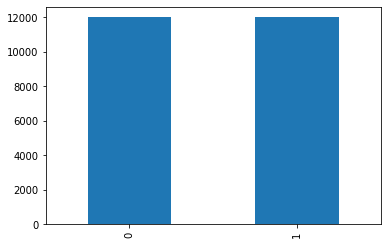

In [36]:
df_up_down_sampled = pd.concat([df_majority, df_minority])
df_up_down_sampled['label'].value_counts().plot(kind='bar')

# Min Max scaler

In [37]:
y = df_up_down_sampled['label']
X = df_up_down_sampled.drop(columns='label')
y_set = y.values
X_set = X.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_set = scaler.fit_transform(X_set)


In [38]:
# import sklearn.external.joblib as extjoblib
import joblib
scaler_filename = "/home/onos/Downloads/flask_SDN/scaler.save"
joblib.dump(scaler, scaler_filename) 

['/home/onos/Downloads/flask_SDN/scaler.save']

In [39]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_X, test_X, train_y, test_y = train_test_split(X_set, y_set, test_size = 0.3)


# build model

In [40]:
# Thay đổi shape của tập X
time_steps = 1
input_train_lstm = train_X.reshape( train_X.shape[0], time_steps, train_X.shape[1] )

input_test_lstm = test_X.reshape( test_X.shape[0], time_steps, test_X.shape[1])


In [41]:
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=64, input_shape=(time_steps, input_train_lstm.shape[2]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

lstm.add(LSTM(units=64, activation='relu', return_sequences=False))


# lop dau vao hinh tron
lstm.add(Dense(1)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
lstm.summary()
file_name = "/home/onos/Downloads/flask_SDN/lstmlocal.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='accuracy', save_best_only=True, mode='auto', period=1, verbose=1)
# early = EarlyStopping(monitor='accuracy')
epoch=100

from time import time
start = time()

history = lstm.fit(input_train_lstm,
                   train_y,
                   epochs=epoch,
                   verbose=1,
                   callbacks=[checkpoint])
                   
print('Total training time: ', time()-start)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 64)             17920     
                                                                 
 lstm_4 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 166,209
Trainable params: 166,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
518/525 [============================>.] - ETA: 0s - loss: 0.4805 - accuracy: 0.8380
Epoch 1: accuracy improved from -inf to 0.83988, saving model to /home/onos/Downloa

KeyboardInterrupt: 

In [ ]:
from keras.utils import plot_model
plot_model(lstm)